In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# librosa has some depreciated code which throws a warning
import librosa as lbs
import librosa.display as lbsd
import IPython.display as ipd
import warnings
warnings.filterwarnings('ignore')

## Exploring Audio Data Waveforms

#### Lets see what librosa can to to help understand the waveform
First load up a sample waveform and see what it contains

In [9]:
mainPath = "/Users/nicholas/Desktop/Misc/Workspace/PythonWorkspace/musicProject/musicdata"

y, sr = lbs.load(mainPath + "/genres_original/reggae/reggae.00019.wav")

print("y:", y)
print("y shape:" ,np.shape(y))
print("sample rate:", sr)
print("length of file in seconds:", len(y)/sr)


y: [-0.02355957 -0.03036499 -0.02444458 ...  0.00683594  0.00024414
 -0.00888062]
y shape: (661794,)
sample rate: 22050
length of file in seconds: 30.013333333333332


Good practice to trim silence from beginning and end of file

In [12]:
audioData = lbs.effects.trim(y)[0]

print("Audio Data:", audioData)
print("Audio Data Shape:", np.shape(audioData))

Audio Data: [-0.02355957 -0.03036499 -0.02444458 ...  0.00683594  0.00024414
 -0.00888062]
Audio Data Shape: (661794,)


#### Lets see how the waveform looks with amplitude over time

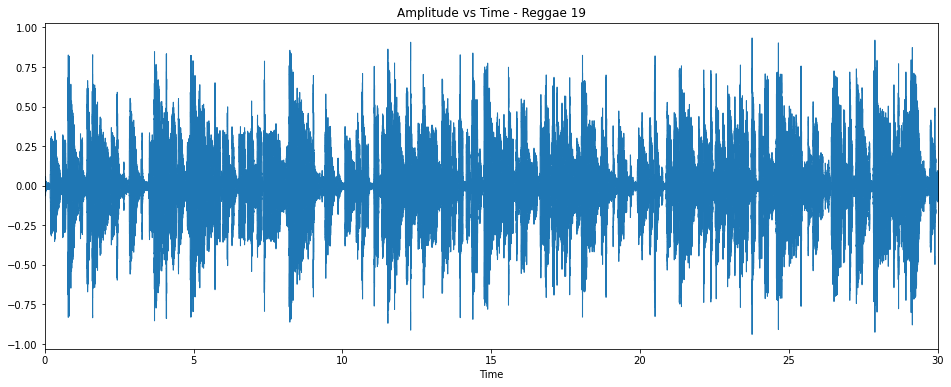

In [16]:
# setup matplotlib figure
plt.figure(figsize = (16, 6))

lbsd.waveshow(audioData, sr);
plt.title("Amplitude vs Time - Reggae 19");
plt.xlim([0,30]);

### Now lets look at more insightful methods of expressing this waveform
#### Firstly, lets generate a fourier transform to see signal in frequency domain